# Install libraries, packages and dataset

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-_keayrfp
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-_keayrfp
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [ ]:
TRAIN_IMG_FOLDER_PATH='/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH='/content/Facial-Expression-Dataset/validation/'

LR=0.001
BATCH_SIZE=64
EPOCHS=20

DEVICE='cuda'
MODEL_NAME='efficientnet_b0'

# Load Dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [ ]:
train_augs=T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation((-15,15)),
    T.ToTensor()
])
valid_augs=T.Compose([
    T.ToTensor()
])
trainset=ImageFolder(TRAIN_IMG_FOLDER_PATH,transform=train_augs)
validset=ImageFolder(VALID_IMG_FOLDER_PATH,transform=valid_augs)

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

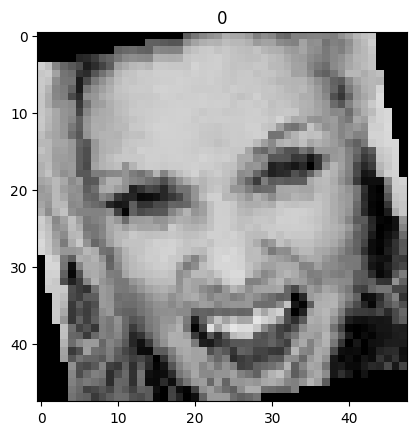

In [ ]:
image,label=trainset[4]
plt.imshow(image.permute(1,2,0))
plt.title(label)

# Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 451
Total no. of batches in validloader : 111


In [ ]:
for images,labels in trainloader:
    break
print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([64, 3, 48, 48])
One label batch shape : torch.Size([64])


# Create Model

In [ ]:
import timm
from torch import nn

In [ ]:
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel, self).__init__()
    self.eff_net=timm.create_model('efficientnet_b0',pretrained=True,num_classes=7)
  def forward(self,images, labels=None):
    logits=self.eff_net(images)
    if labels != None:
      loss=nn.CrossEntropyLoss()(logits,labels)
      return logits, loss
    return logits

In [ ]:
model=FaceModel()
model.to(DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv

# Create Train and Eval Function

In [ ]:
from tqdm import tqdm

In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train_fn(model,dataloader,optimizer, current_epo):
  model.train()
  total_loss=0.0
  total_acc=0.0
  tk=tqdm(dataloader, desc='EPOCH'+ '[TRAIN]'+str(current_epo+1)+"/"+str(EPOCHS))

  for t, data in enumerate(tk):
    images,labels=data
    images=images.to(DEVICE)
    labels=labels.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,labels)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
    total_acc+=multiclass_accuracy(logits,labels)
    tk.set_postfix({'loss' :'%6f'%float( total_loss/(t+1)), 'acc' : '%6f'%float(total_acc/(t+1)),})
  return total_loss/len(dataloader), total_acc/len(dataloader)


In [ ]:
def eval_fn(model,dataloader, current_epo):
  model.eval()
  total_loss=0.0
  total_acc=0.0
  tk=tqdm(dataloader, desc='EPOCH'+ '[VALID]'+str(current_epo+1)+"/"+str(EPOCHS))

  for t, data in enumerate(tk):
    images,labels=data
    images=images.to(DEVICE)
    labels=labels.to(DEVICE)


    logits,loss=model(images,labels)

    total_loss+=loss.item()
    total_acc+=multiclass_accuracy(logits,labels)
    tk.set_postfix({'loss' :'%6f'%float( total_loss/(t+1)), 'acc' : '%6f'%float(total_acc/(t+1)),})
  return total_loss / len(dataloader), total_acc / len(dataloader)

# Create Training Loop

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss=np.inf

for i in range(EPOCHS):
  train_loss, train_acc=train_fn(model,trainloader,optimizer,i)
  valid_loss, valid_acc=eval_fn(model,validloader,i)
  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print("SAVED-BEST-WEIGHTS")
    best_valid_loss=valid_loss



EPOCH[VALID]1/20: 100%|██████████| 111/111 [00:04<00:00, 22.54it/s, loss=1.429656, acc=0.477272]


SAVED-BEST-WEIGHTS


EPOCH[VALID]2/20: 100%|██████████| 111/111 [00:04<00:00, 23.29it/s, loss=1.208960, acc=0.540530]


SAVED-BEST-WEIGHTS


EPOCH[VALID]3/20: 100%|██████████| 111/111 [00:04<00:00, 25.53it/s, loss=1.132447, acc=0.572559]


SAVED-BEST-WEIGHTS


EPOCH[VALID]4/20: 100%|██████████| 111/111 [00:04<00:00, 25.87it/s, loss=1.089851, acc=0.586972]


SAVED-BEST-WEIGHTS


EPOCH[VALID]5/20: 100%|██████████| 111/111 [00:05<00:00, 22.02it/s, loss=1.073758, acc=0.599727]


SAVED-BEST-WEIGHTS


EPOCH[VALID]6/20: 100%|██████████| 111/111 [00:04<00:00, 22.49it/s, loss=1.045962, acc=0.609906]


SAVED-BEST-WEIGHTS


EPOCH[VALID]8/20: 100%|██████████| 111/111 [00:04<00:00, 25.92it/s, loss=1.039312, acc=0.614692]


SAVED-BEST-WEIGHTS


EPOCH[VALID]9/20: 100%|██████████| 111/111 [00:05<00:00, 21.07it/s, loss=1.035340, acc=0.618492]


SAVED-BEST-WEIGHTS


EPOCH[VALID]10/20: 100%|██████████| 111/111 [00:04<00:00, 25.24it/s, loss=1.028127, acc=0.630479]


SAVED-BEST-WEIGHTS


EPOCH[VALID]12/20: 100%|██████████| 111/111 [00:05<00:00, 20.08it/s, loss=1.023285, acc=0.633446]


SAVED-BEST-WEIGHTS


EPOCH[VALID]20/20: 100%|██████████| 111/111 [00:04<00:00, 24.61it/s, loss=1.198694, acc=0.638968]


# Inference

In [ ]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None


In [ ]:
def view_classify(img, ps, pred_label=None, true_label=None):
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1, 2, 0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5, 9), ncols=2)

    ax1.imshow(img, cmap='gray')  # use cmap for grayscale
    ax1.axis('off')
    title = f"Pred: {pred_label}"
    if true_label is not None:
        title += f" | True: {true_label}"
    ax1.set_title(title)

    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(range(len(classes)))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()


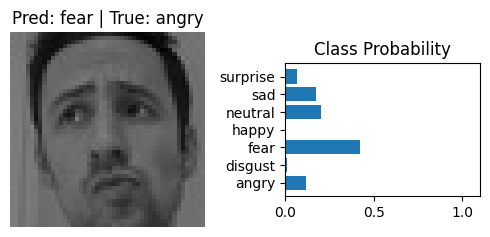

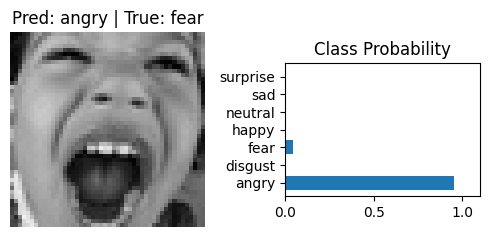

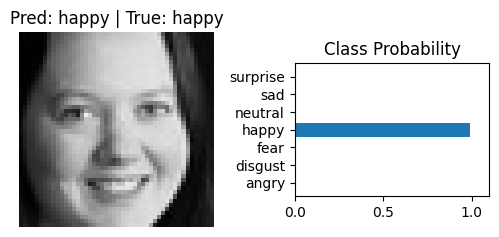

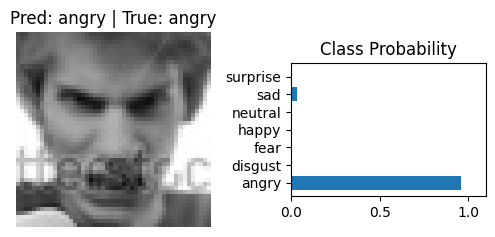

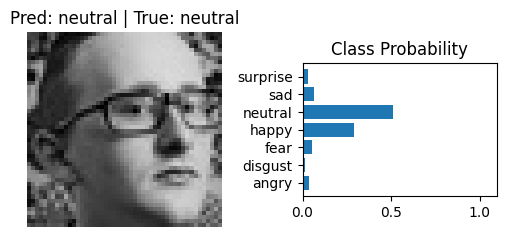

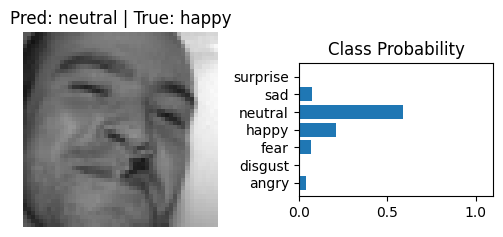

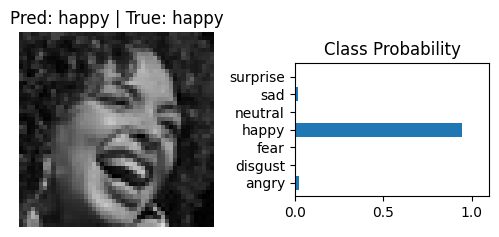

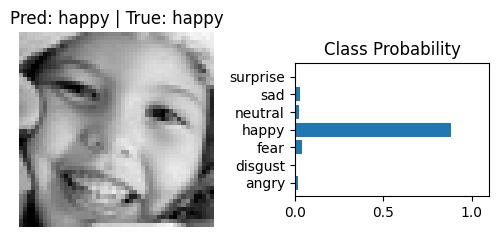

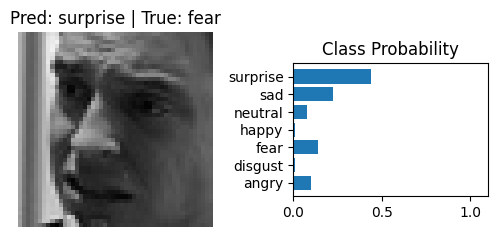

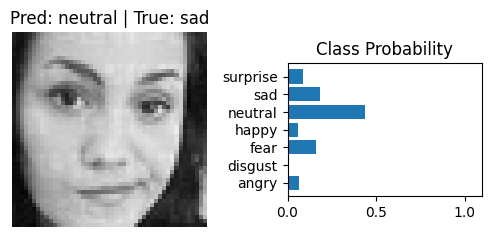

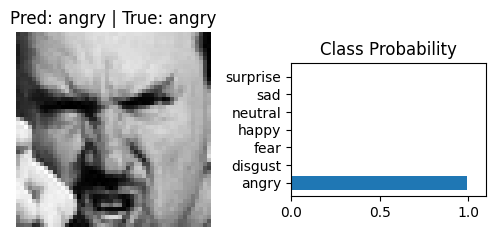

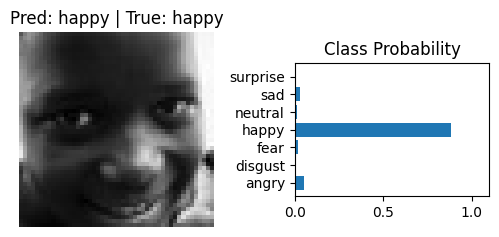

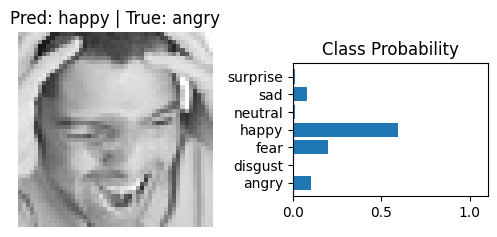

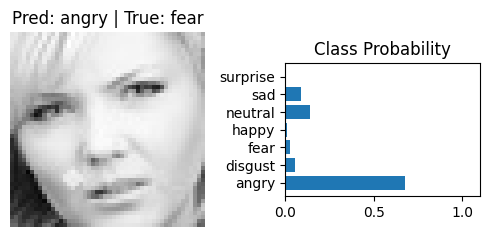

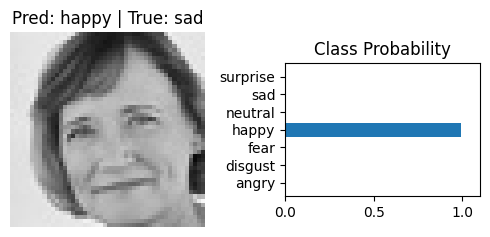

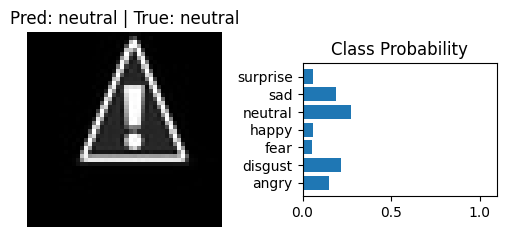

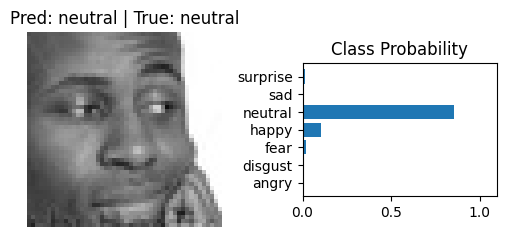

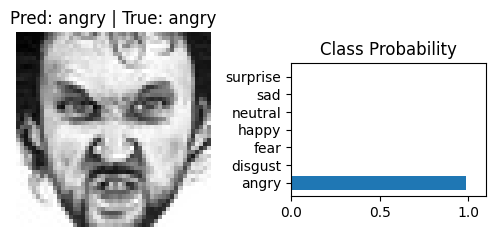

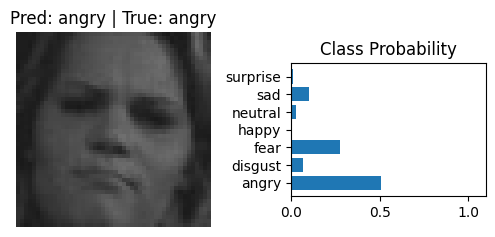

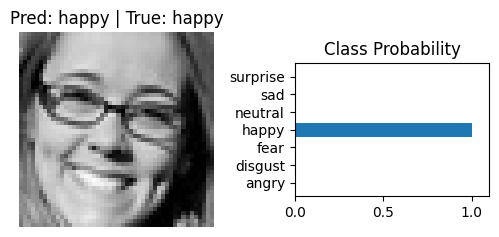

In [ ]:
import random
import torch.nn.functional as F

# Load model weights
model.load_state_dict(torch.load("best-weights.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Class labels (must match the output order)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Sample 20 random test images
indices = random.sample(range(len(validloader.dataset)), 20)
subset = torch.utils.data.Subset(validloader.dataset, indices)
subset_loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

# Inference and visualization
for images, labels in subset_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        true_idx = labels.item()

    pred_label = class_names[pred_idx]
    true_label = class_names[true_idx]

    view_classify(images.squeeze().cpu(), probs.squeeze(), pred_label, true_label)
